In [ ]:
! pip install tensorflow

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [4]:
main_data_dir = 'D:/Projects/HerbScan/Dataset/Segmented Medicinal Leaf Images'
batch_size = 32
num_classes = len(os.listdir(main_data_dir))
epochs = 10

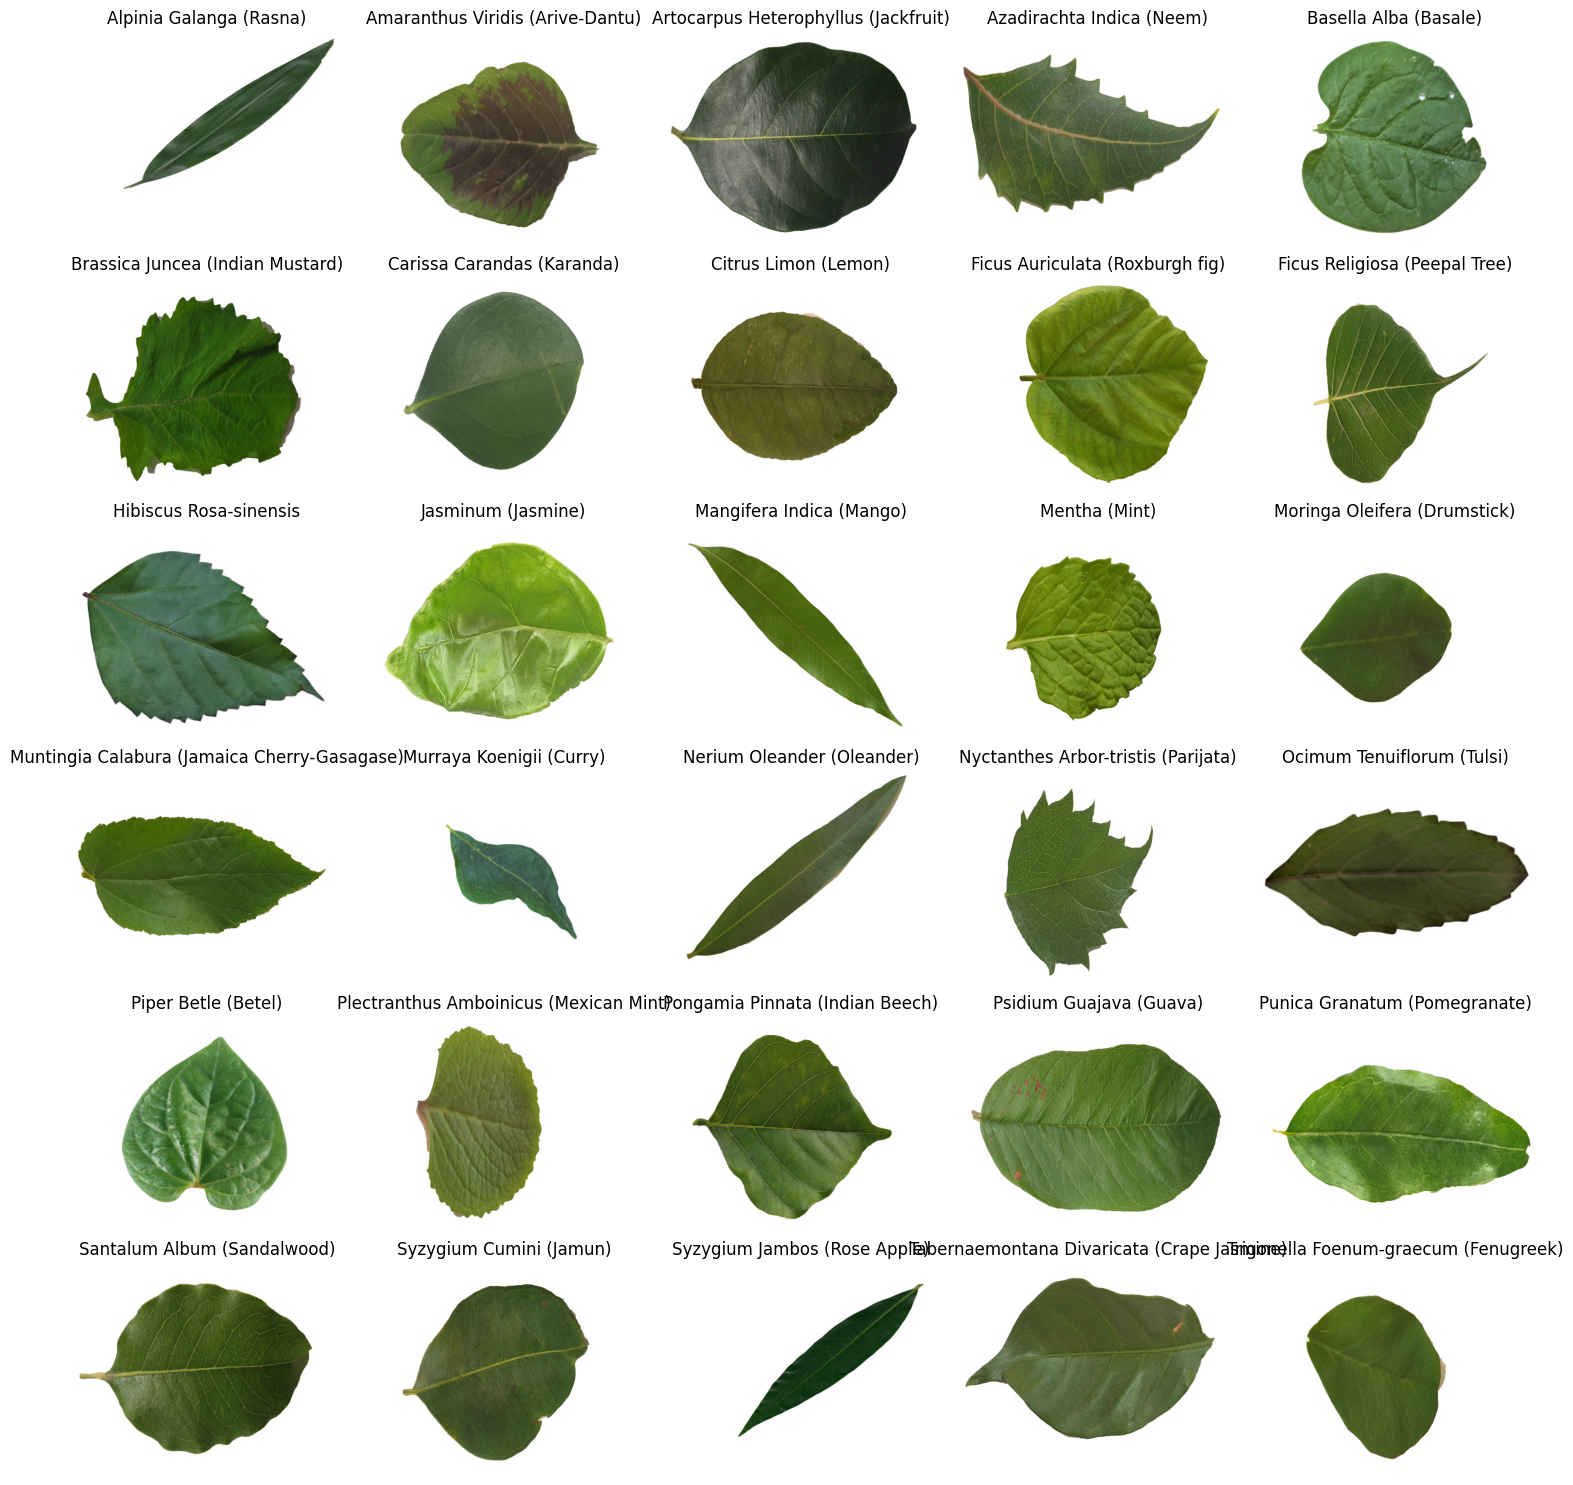

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# List all subdirectories (class folders) in the main directory
class_folders = os.listdir(main_data_dir)

# Set the number of images per row
images_per_row = 5

# Calculate the number of rows needed
num_rows = math.ceil(len(class_folders) / images_per_row)

# Create a grid of subplots
fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 15))

# Display images in rows with titles
for i, class_folder in enumerate(class_folders):
    # Get the first image file in the class folder
    class_folder_path = os.path.join(main_data_dir, class_folder)
    image_files = [f for f in os.listdir(class_folder_path) if f.endswith('.jpg')]
    if image_files:
        first_image_path = os.path.join(class_folder_path, image_files[0])
        
        # Load the image
        img = mpimg.imread(first_image_path)
        
        # Calculate the row and column indices for the subplot
        row = i // images_per_row
        col = i % images_per_row
        
        # Display the image in the corresponding subplot
        axs[row, col].imshow(img)
        axs[row, col].set_title(class_folder)
        axs[row, col].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [6]:
# Split ratio between training and validation data
split_ratio = 0.8

# Create ImageDataGenerator with data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=1 - split_ratio  # Set validation split
)

In [7]:
# Load and preprocess training data using the generator
train_generator = train_datagen.flow_from_directory(
    main_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify training subset
)

# Load and preprocess validation data using the generator
validation_generator = train_datagen.flow_from_directory(
    main_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify validation subset
)

Found 1485 images belonging to 30 classes.
Found 350 images belonging to 30 classes.


In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [9]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


9406464/9406464 [==============================] - 2s 0us/step


Epoch 1/10
46/46 [==============================] - 88s 2s/step - loss: 1.7644 - accuracy: 0.5224 - val_loss: 0.6068 - val_accuracy: 0.8625
Epoch 2/10
46/46 [==============================] - 60s 1s/step - loss: 0.5869 - accuracy: 0.8231 - val_loss: 0.3975 - val_accuracy: 0.8875
Epoch 3/10
46/46 [==============================] - 64s 1s/step - loss: 0.4041 - accuracy: 0.8727 - val_loss: 0.3259 - val_accuracy: 0.9125
Epoch 4/10
46/46 [==============================] - 60s 1s/step - loss: 0.2976 - accuracy: 0.9050 - val_loss: 0.3127 - val_accuracy: 0.9094
Epoch 5/10
46/46 [==============================] - 64s 1s/step - loss: 0.2950 - accuracy: 0.9050 - val_loss: 0.2177 - val_accuracy: 0.9281
Epoch 6/10
46/46 [==============================] - 58s 1s/step - loss: 0.2349 - accuracy: 0.9284 - val_loss: 0.2005 - val_accuracy: 0.9344
Epoch 7/10
46/46 [==============================] - 59s 1s/step - loss: 0.1718 - accuracy: 0.9443 - val_loss: 0.2792 - val_accuracy: 0.9125
Epoch 8/10
46/46 [==

In [10]:
model.save('plant_identification_model.h5')